# CartPole

1. DQN (double)
2. Q-Learning
3. memory replay


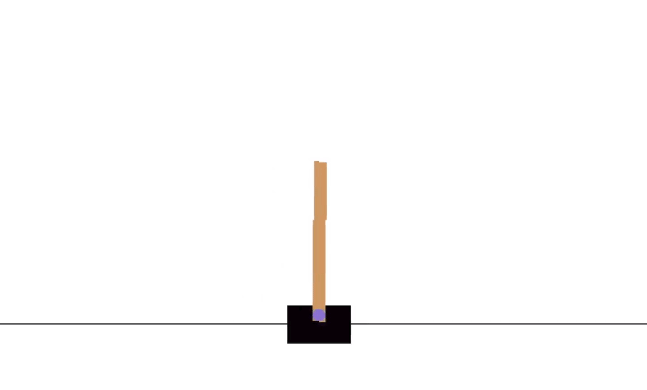



In [67]:
import gym
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch
import copy
import numpy as np
import torch.optim as optimizer
from IPython import display
import time

## Memory Replay

In [68]:
class MemoryReplay:
    def __init__(self, memory_size):
        self.queue = []
        self.memory_size = memory_size
        
    def add(self, mc_sample_tuple):
        if len(self.queue) >= self.memory_size:
            self.queue.pop(0)
        self.queue.append(mc_sample_tuple)
    
    def sample(self, batch_size):
        if batch_size > len(self.queue):
            return self.queue
        else:
            return random.sample(self.queue, batch_size)
        
    def __len__(self):
        return len(self.queue)

In [ ]:
replay.queue

## DQN

In [69]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # [position, velocity, action]
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.out(x)   

## Agent

In [90]:
class Agent:
    def __init__(self, DQN_value_net, DQN_target_net, update_per_epoch):
        self.target_net = DQN_target_net
        self.value_net = DQN_value_net
        self.loss_function = nn.MSELoss()
        self.optimizer = optimizer.Adam(self.value_net.parameters(), lr=0.01)
        self.action = np.array([0, 1])
        self.update_per_epoch = update_per_epoch
        self.count = 0
    
    
    def step(self, state_array, e_threshold, net='value', strategy='egreedy'):
        if strategy == 'egreedy':
            if random.random() > e_threshold:
                action = self.get_max_action(net, state_array)
            else:
                action = np.random.choice(self.action)

        elif strategy == 'max':
            action = self.get_max_action(net, state_array)

        return action
    
    
    def get_actions(self, net, state_array):
        
        # 构造数据
        data_batch = torch.Tensor([np.r_[state_array, x] for x in self.action])
        
        if net == 'value':
            actions = self.value_net(data_batch).squeeze()
        if net == 'target':
            actions = self.target_net(data_batch).squeeze()
        return actions
        
        
    def get_max_action(self, net, state_array):
        max_action = self.get_actions(net, state_array).topk(1)[1].item()
        return max_action
        
        
    def learn(self, data_batch, gamma):
        
        # features & label 构造
        x, y_true = self.creat_features_labels(data_batch, gamma)
        
        # 清空梯度
        self.optimizer.zero_grad()
        
        # 训练
        y_pre = self.value_net(x)
        loss = self.loss_function(y_pre, y_true)
        loss.backward()

        # 达到固定次数更新 target_net
        self.count += 1
        if self.count > self.update_per_epoch:
            self.update_target_net
        
        return loss.item()
        
        
    def creat_features_labels(self, data_batch, gamma):
        x = []
        y = []
        
        for data in data_batch:
            print(data)
            
            # x 构造
            x.append(np.r_[data[0], data[1]])
            
            # y 构造
            if  data[4]:  # done
                y.append(1)
            else:
                max_action_value = self.get_actions('target', data[3]).topk(1)[0].item()
                y.append(data[2] + gamma * max_action_value)
        
        return torch.Tensor(x), torch.Tensor(y).view(-1, 1)
        
    
    def update_target_net(self):
        self.target_net = copy.deepcopy(self.value_net).eval()
        self.count = 0

## Setting

In [91]:
# Envirement
envirement = gym.make('CartPole-v0')

# Replay
MEMORY_SIZE = 2000
replay = MemoryReplay(MEMORY_SIZE)

# DQN
model_value = DQN()
model_target = DQN()

# Agent
UPDATE_PER_LEARN = 2560
agent = Agent(model_value, model_target, UPDATE_PER_LEARN)

# Others
E_THRESHOLD = 0.1
BATCH_SIZE = 1024
GAMMA = 0.9

## RL Training

In [92]:
loss_mean_list = []
reward_list = []


for i in range(1):

    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0
    loss_list = []
    start = time.time()
#     E_THRESHOLD = 1 / 1 + (0.01*i)
    
    while not done :

        # agent 使用value_net 获取下一步 action
        action = agent.step(current_state, E_THRESHOLD, 'value', 'egreedy')

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 增加经验
        replay.add((current_state, action, reward, next_state, done))

        # 提取经验
        data_batch = replay.sample(BATCH_SIZE)

        # 网络更新参数
        loss = agent.learn(data_batch, GAMMA)
        loss_list.append(loss)

        # 进入下一个状态
        current_state = next_state

    loss_mean_list.append(np.array(loss_list).mean())
    reward_list.append(reward_temp)
    duration = round(time.time() - start, 1)
    
    
    print(f'epoch: {i+1},  loss: {round(np.array(loss_list).mean(), 6)},  reward: {reward_temp},  second: {duration}')

#     # 展示loss曲线
#     plt.figure(figsize=(16, 8))
    
#     plt.subplot2grid((5,1), (0,0), 2)
#     plt.title('loss')
#     plt.plot(loss_mean_list, color='b')
    
#     plt.subplot2grid((5,1), (3,0), 2)
#     plt.title('reward')
#     plt.plot(reward_list, color='r')
    
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

(array([-0.03798844, -0.01504656, -0.03259924, -0.02514712]), 1, 1.0, array([-0.03828937,  0.18052736, -0.03310218, -0.32793461]), False)
tensor([-0.0786, -0.0580], grad_fn=<SqueezeBackward0>)
tensor([-0.0112,  0.0258], grad_fn=<SqueezeBackward0>)
(array([-0.03798844, -0.01504656, -0.03259924, -0.02514712]), 1, 1.0, array([-0.03828937,  0.18052736, -0.03310218, -0.32793461]), False)
tensor([-0.0786, -0.0580], grad_fn=<SqueezeBackward0>)
(array([-0.03828937,  0.18052736, -0.03310218, -0.32793461]), 1, 1.0, array([-0.03467882,  0.37610455, -0.03966087, -0.63086994]), False)
tensor([-0.0929, -0.0570], grad_fn=<SqueezeBackward0>)
(array([-0.03798844, -0.01504656, -0.03259924, -0.02514712]), 1, 1.0, array([-0.03828937,  0.18052736, -0.03310218, -0.32793461]), False)
tensor([-0.0786, -0.0580], grad_fn=<SqueezeBackward0>)
(array([-0.03828937,  0.18052736, -0.03310218, -0.32793461]), 1, 1.0, array([-0.03467882,  0.37610455, -0.03966087, -0.63086994]), False)
tensor([-0.0929, -0.0570], grad_fn=

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(reward_list)
plt.show()

## Playing

In [ ]:
reward_list = []

for i in range(500):

    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0

    while not done :

        # agent 使用value_net 获取下一步 action
        action = agent.step(current_state, E_THRESHOLD, 'value', 'max')

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 进入下一个状态
        current_state = next_state
    reward_list.append(reward_temp)

print(np.array(reward_list).mean())

## Random Playing

In [ ]:
reward_list = []

for i in range(500):
    
    # 初始状态
    done = False
    current_state = envirement.reset()
    reward_temp = 0

    while not done :
        action = random.choice([0,1])

        # 从环境获取信息
        next_state, reward, done, info = envirement.step(action)
        reward_temp += reward

        # 进入下一个状态
        current_state = next_state
        reward_list.append(reward_temp)

print(np.array(reward_list).mean())

In [ ]:
next_state, reward, done, info = envirement.step(action)

In [ ]:
next_state

In [ ]:
reward

In [ ]:
done

In [ ]:
info

In [75]:
data_batch[0]

(array([ 0.02894037, -0.02437702, -0.03604944, -0.0175876 ]),
 1,
 1.0,
 array([ 0.02845283,  0.17124288, -0.0364012 , -0.32142305]),
 False)